In [1]:
from keras.metrics import mean_squared_error
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from typing import Tuple
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Dropout, Lambda
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import Input, LSTM, Dense, MaxPooling1D, Conv1D, UpSampling1D, Reshape, TimeDistributed, Bidirectional

In [2]:
# Constants
INPUT_FEATURES = 26                # Number of input features (e.g., temperature, humidity, etc.)
SEQUENCE_LEN = 7 * 24              # 7 days of hourly data
OUTPUT_LEN = 1 * 24                # 24 hours in the next day
OUTPUT_FEATURES = 3 * OUTPUT_LEN   # Predicting 3 features for each day
LSTM_UNITS = 128                   # Number of LSTM units
DENSE_UNITS = 128                  # Number of Dense layer units
DROPOUT_RATE = 0.2                 # Dropout rate

In [3]:
def create_sequences(data):
    X, y = [], []
    for i in range(len(data) - SEQUENCE_LEN - OUTPUT_LEN):
        X.append(data[i: i + SEQUENCE_LEN])
        y.append(data[i + SEQUENCE_LEN: i + SEQUENCE_LEN + OUTPUT_LEN, :3].flatten()) # Taking the first 3 features for the next 24 hours
    return np.array(X), np.array(y)


def invert_scale(data, scaler):
    copy_data = data.copy()
    for i in range(3):
        std, mean = scaler.scale_[i], scaler.mean_[i]
        copy_data[:, i::3] = data[:, i::3] * std + mean
    return copy_data


def MSE(y_true, y_pred):
    T_mse = np.mean((y_true[:, 0::3] - y_pred[:, 0::3])**2, axis=0).reshape(1, -1)
    P_mse = np.mean((y_true[:, 1::3] - y_pred[:, 1::3])**2, axis=0).reshape(1, -1)
    R_mse = np.mean((y_true[:, 2::3] - y_pred[:, 2::3])**2, axis=0).reshape(1, -1)
    
    MSE_by_hour = np.append(np.append(T_mse, P_mse, axis=0), R_mse, axis=0)
    
    return MSE_by_hour, np.mean(MSE_by_hour, axis=1), np.mean(MSE_by_hour)


def plot_one_prediction(idx: int, X_true, y_true, y_pred, scaler, figsize: Tuple[int] = (15, 10)):
    x = range(SEQUENCE_LEN + OUTPUT_LEN)
    x1, x2 = x[1:1 + SEQUENCE_LEN], x[SEQUENCE_LEN:]
    labels = ['Temperature [C]', 'Pressure [hPa]', 'Rainfall [mm]']

    fig, axs = plt.subplots(3, figsize=figsize)
    fig.suptitle('Weather Forecast: Actual vs Predicted')
    for i in range(3):
        std, mean = scaler.scale_[i], scaler.mean_[i]
        axs[i].plot(x1, X_true[idx + 1, :, i] * std + mean, label='Given data', color='green')
        axs[i].plot(x2, y_true[:, i::3][idx] * std + mean, label='Actual', color='blue')
        axs[i].plot(x2, y_pred[:, i::3][idx] * std + mean, label='Predicted', color='red')
        axs[i].set_ylabel(labels[i])
        axs[i].grid()
        axs[i].legend()
    axs[2].set_xlabel('Time (Hours)')
    plt.show()

In [4]:
data = pd.read_csv('../data/preprocessed_data/complete_krk_2017-22.csv')
data = data.drop('timestamp', axis=1)
cols = data.columns

In [5]:
# Assuming 'data' is your dataset with shape (total_hours, 26_features)
# and 'total_hours' is a multiple of 24

# Normalize your data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)
data_normalized

array([[-1.84487084,  0.96334401, -0.13402178, ..., -0.15217187,
        -0.12556201, -0.28491282],
       [-1.85603007,  0.93829589, -0.13402178, ..., -0.15217187,
        -0.12556201, -0.28491282],
       [-1.52125303,  0.85062749, -0.13402178, ..., -0.15217187,
        -0.12556201, -0.28491282],
       ...,
       [-0.14866714,  0.43733359, -0.13402178, ..., -0.15217187,
        -0.12556201, -0.28491282],
       [-0.04823402,  0.43733359, -0.13402178, ..., -0.15217187,
        -0.12556201, -0.28491282],
       [-0.40532954,  0.42480953, -0.13402178, ..., -0.15217187,
        -0.12556201, -0.28491282]])

In [6]:
# Create sequences
X, y = create_sequences(data_normalized)

In [7]:
train_size = 24 * (365 * 3 + 366)
val_size = 24 * 365

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

In [8]:
input_layer = Input(shape=(168, 26))  # 7 days * 24 hours, 26 parameters

reshape = Reshape((26, 168)) (input_layer)
# Downsampling
conv1 = Conv1D(filters=102, kernel_size=7, activation='relu', strides=1, padding="causal") (reshape)
lstm1 = Bidirectional(LSTM(102, return_sequences=True))(conv1)

lstm2 = Bidirectional(LSTM(48, return_sequences=False))(lstm1)

# Output layer
output_layer = Dense(72, activation='linear') (lstm2)

# Build the model
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='mean_squared_error')  # Adjust optimizer and loss as needed
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 168, 26)]         0         
                                                                 
 reshape (Reshape)           (None, 26, 168)           0         
                                                                 
 conv1d (Conv1D)             (None, 26, 102)           120054    
                                                                 
 bidirectional (Bidirection  (None, 26, 204)           167280    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 96)                97152     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 72)                6984  

In [9]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
1096/1096 [==============================] - 79s 64ms/step - loss: 0.4594 - val_loss: 0.4137
Epoch 2/20
1096/1096 [==============================] - 57s 52ms/step - loss: 0.3879 - val_loss: 0.4351
Epoch 3/20
1096/1096 [==============================] - 56s 51ms/step - loss: 0.3503 - val_loss: 0.4333
Epoch 4/20
1096/1096 [==============================] - 58s 53ms/step - loss: 0.3292 - val_loss: 0.4370
Epoch 5/20
1096/1096 [==============================] - 59s 54ms/step - loss: 0.3142 - val_loss: 0.4382
Epoch 6/20
1096/1096 [==============================] - 58s 53ms/step - loss: 0.3031 - val_loss: 0.4406
Epoch 7/20
1096/1096 [==============================] - 58s 53ms/step - loss: 0.2940 - val_loss: 0.4475
Epoch 8/20
1096/1096 [==============================] - 58s 53ms/step - loss: 0.2891 - val_loss: 0.4409
Epoch 9/20
1096/1096 [==============================] - 60s 54ms/step - loss: 0.2854 - val_loss: 0.4485
Epoch 10/20
1096/1096 [==============================] - 61s 56m

In [10]:

model.save('CNN&LSTM_29-12-2023_baseline')

INFO:tensorflow:Assets written to: CNN&LSTM_29-12-2023_baseline\assets


INFO:tensorflow:Assets written to: CNN&LSTM_29-12-2023_baseline\assets


In [18]:
from keras.models import load_model

model = load_model('CNN&LSTM_29-12-2023_baseline')
history = model.history

In [11]:
loss = history["loss"]
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, "b", label="Training loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

TypeError: 'History' object is not subscriptable

In [12]:
# Make predictions
y_pred = model.predict(X_test)

268/268 [==============================] - 7s 17ms/step


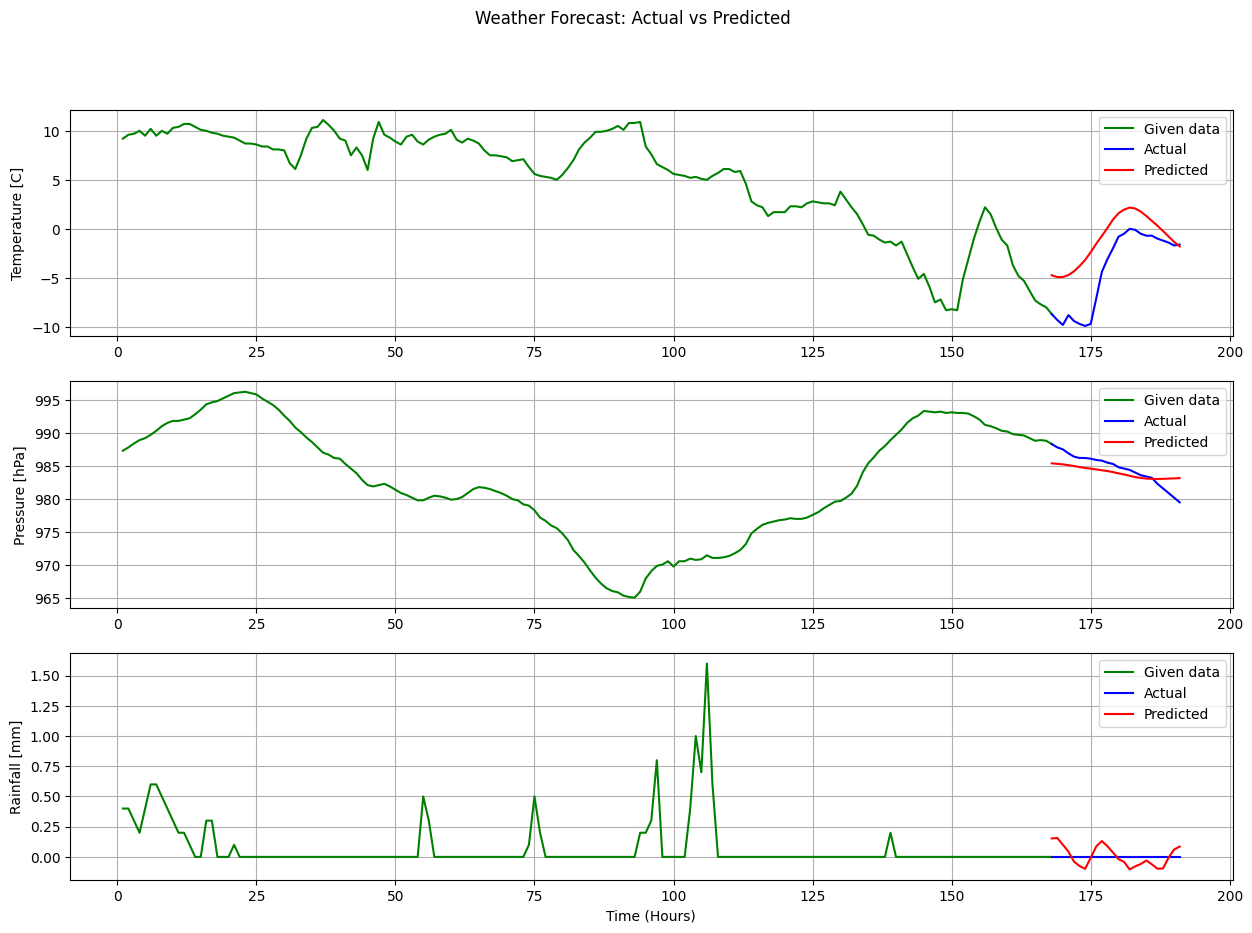

In [17]:
plot_one_prediction(0, X_test, y_test, y_pred, scaler)

In [18]:
MSE(invert_scale(y_test, scaler), invert_scale(y_pred, scaler))[0]

array([[ 5.40179317,  5.63146934,  6.00276097,  6.44483956,  6.92959744,
         7.43207552,  7.94634769,  8.41867498,  8.84304089,  9.21132424,
         9.56337342,  9.91881381, 10.21455335, 10.51357813, 10.78804351,
        11.04657576, 11.29943482, 11.52207677, 11.72269225, 11.8701258 ,
        12.00235624, 12.16742353, 12.28784747, 12.39191702],
       [ 3.39356858,  3.45977115,  3.6957419 ,  4.10238198,  4.68131802,
         5.38478488,  6.22404768,  7.19418738,  8.26301259,  9.44444854,
        10.71533652, 12.05795331, 13.46358608, 14.91806895, 16.41080689,
        17.93503504, 19.47680487, 21.02370976, 22.561323  , 24.10767163,
        25.65981862, 27.21781191, 28.74106959, 30.25569374],
       [ 0.28764784,  0.28983411,  0.28659704,  0.28923695,  0.2949509 ,
         0.29465428,  0.29796966,  0.29621996,  0.28957166,  0.28629382,
         0.28866613,  0.29333126,  0.29282394,  0.29363498,  0.29379295,
         0.30024309,  0.30025546,  0.29636947,  0.2916568 ,  0.29764425,
  

In [19]:
MSE(invert_scale(y_test, scaler), invert_scale(y_pred, scaler))[1]

array([ 9.56544732, 14.18283136,  0.29412482])